# Predicting Prices Of Airbnb


# Akshay Rane : CWID - 10442740

In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
import pandas as pd
import numpy as np

from math import sin, cos, sqrt, atan2, radians
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import collections

%matplotlib inline

In [2]:
def load_dataset(file_name):
    dataframe = pd.read_csv(file_name, index_col='id',low_memory=False)
    dataframe.reset_index(drop=True, inplace=True)
    
    return dataframe

In [3]:
dataframe = load_dataset("listings.csv")

# Feature engineering

In [4]:
def view_dataset_description(dataframe):
    return dataframe.describe()

In [5]:
view_dataset_description(dataframe = dataframe)
#dataframe.shape

,scrape_id,thumbnail_url,medium_url,xl_picture_url,host_id,host_acceptance_rate,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,1.945600e+04,0.0,0.0,0.0,1.945600e+04,0.0,19453.000000,19453.000000,0.0,19456.000000,...,17014.000000,17003.000000,17010.000000,17004.000000,17005.000000,19456.000000,19456.000000,19456.000000,19456.000000,17251.000000
mean,2.019031e+13,NaN,NaN,NaN,5.099088e+07,NaN,6.611988,6.611988,NaN,52.365265,...,9.467145,9.739458,9.786831,9.436250,9.176478,4.805818,4.371351,0.418894,0.015574,0.974460
std,3.007890e-01,NaN,NaN,NaN,5.978800e+07,NaN,35.625623,35.625623,NaN,0.015944,...,0.869189,0.637504,0.604092,0.722428,0.808513,23.598488,23.411975,1.118385,0.128307,1.273213
min,2.019031e+13,NaN,NaN,NaN,3.159000e+03,NaN,0.000000,0.000000,NaN,52.289270,...,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,2.019031e+13,NaN,NaN,NaN,8.307630e+06,NaN,1.000000,1.000000,NaN,52.355180,...,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,1.000000,0.000000,0.000000,0.250000
50%,2.019031e+13,NaN,NaN,NaN,2.418935e+07,NaN,1.000000,1.000000,NaN,52.364610,...,10.000000,10.000000,10.000000,10.000000,9.000000,1.000000,1.000000,0.000000,0.000000,0.550000
75%,2.019031e+13,NaN,NaN,NaN,7.160899e+07,NaN,1.000000,1.000000,NaN,52.375090,...,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,1.000000,0.000000,1.100000
max,2.019031e+13,NaN,NaN,NaN,2.471790e+08,NaN,769.000000,769.000000,NaN,52.424710,...,10.000000,10.000000,10.000000,10.000000,10.000000,211.000000,209.000000,15.000000,3.000000,13.880000


# Filtering the required columns



In [0]:
def perform_feature_engineering(dataframe):

    column_names_null_values = dataframe.columns[dataframe.isnull().any()]
    null_values_count =  (dataframe[column_names_null_values].isnull().sum()).to_dict()
    number_of_rows = dataframe.shape[0]
    columns_half_null_values = []

    for columns in column_names_null_values:

        if float(null_values_count.get(columns)) > (0.5*number_of_rows):
            columns_half_null_values.append(columns)
        
    dataframe.drop(columns = columns_half_null_values, inplace = True)
                        
    features_to_consider = ["name","street","transit","latitude","longitude","property_type","room_type",\
                            "accommodates","bathrooms","bedrooms","beds","bed_type","amenities","price",\
                            "security_deposit","cleaning_fee","guests_included"]
    dataframe = dataframe[features_to_consider]

    dataframe["security_deposit"].fillna(0, inplace = True)
    dataframe["cleaning_fee"].fillna(0, inplace = True)
    

    dataframe = dataframe[np.isfinite(dataframe.beds)]
    dataframe = dataframe[np.isfinite(dataframe.bathrooms)]
    dataframe.bedrooms.fillna(value=0, inplace = True)
    
    return dataframe



In [8]:
dataframe = perform_feature_engineering(dataframe)
dataframe.reset_index(inplace = True, drop = True)
dataframe.shape
#dataframe

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


(19437, 17)

# Deriving features from existing features

#### Calculating the number of amenities offered by the listings.

In [0]:
def count_amenties(dataframe):
    
    amenities_count = []
    amenities_list = list(dataframe.amenities)

    #amenities

    for amenities in amenities_list:
        amenities = amenities.replace("{","")
        amenities = amenities.replace("}","")
        amenities_count.append(len(amenities.split(",")))
    
    dataframe["amenities_count"] = amenities_count

    dataframe.drop("amenities" ,axis = 1,inplace = True)
    
    return dataframe


In [10]:
dataframe = count_amenties(dataframe)
dataframe.shape

(19437, 17)

#### Calculating the mode of transports available to the listings.

In [0]:


def calculate_distance_between_two_locations(latitude_1,longitude_1,latitude_2,longitude_2,):
    radius_of_earth = 6373.0    # approximate radius of earth in km


    latitude_1 = radians(latitude_1)
    longitude_1 = radians(longitude_1)
    latitude_2 = radians(latitude_2)
    longitude_2 = radians(longitude_2)

    diff_longitude = abs(longitude_2 - longitude_1)
    diff_latitude = abs(latitude_2 - latitude_1)

    area = sin(diff_latitude / 2.0)**2 + cos(latitude_1) * cos(longitude_1) * sin(diff_longitude / 2.0)**2
    c = 2 * atan2(sqrt(area), sqrt(1 - area))

    distance = radius_of_earth * c

    return distance


def caluclate_modes_of_trasnport(dataframe):
    
    transit_ways = ("bus","tram","foot","bicycle","bikes","cab","station","carrentals","bikerentals",\
                "taxi","transport","walk","walking","busstop","tram-stop","metro","airport")
    
    weights_transit_ways = {"bus":1,"tram":1,"foot":8,"bicycle":8,"bikes":1,"cab":1,"station":3,"carrentals":1,\
                            "bikerentals":2, "tram-stop":4, "metro":4, "airport": 3,\
                            "taxi":2,"transport":1,"walk":8,"walking":8,"busstop":1}
    
    transit_counts = []
    number_of_rows = dataframe.shape[0]

    for value in dataframe.transit:
        transit_count = 0
        value = str(value)
        value = value.lower()
       
        if value != "nan":
            for transit_way in transit_ways:
                if transit_way in value:
                    transit_count = transit_count + weights_transit_ways[transit_way]
                    
            transit_counts.append(transit_count)
        else:
            
            transit_counts.append(-1)
    
    #print("ashdasbhad")
    # minimum distance from neighbors having transit facilities is 0.5 km
    # this distance is walkable
    threshold_distance = 0.5
    latitude_locations = dataframe.latitude.values
    longitude_locations = dataframe.longitude.values
    
    
    distance_matrix = [[-1 for x in range(number_of_rows)] for y in range(number_of_rows)] 
    
    for current_dwelling in range(number_of_rows):
        realtive_neighbors_transit_counts = []
        
        if transit_counts[current_dwelling] == -1:
          
            
            for neighbor in range(number_of_rows):
                distance_neighbor = 0.0
                if transit_counts[neighbor] > 0:
                    
                    if distance_matrix[current_dwelling][neighbor] == -1:
                        
                        distance_neighbor = calculate_distance_between_two_locations(latitude_locations[current_dwelling],\
                                                                                 longitude_locations[current_dwelling],\
                                                                                     latitude_locations[neighbor],\
                                                                                     longitude_locations[neighbor])
                        
                        distance_matrix[current_dwelling][neighbor] = distance_neighbor      
                        distance_matrix[neighbor][current_dwelling] = distance_neighbor
                        
                    else:
                        distance_neighbor = distance_matrix[current_dwelling][neighbor]
                        
                    
                if distance_neighbor <= threshold_distance:
                    realtive_neighbors_transit_counts.append(transit_counts[neighbor])
    
            if (len(realtive_neighbors_transit_counts) == 0):
                transit_counts[current_dwelling] = 0
            else:
                
                counter=collections.Counter(realtive_neighbors_transit_counts)
                most_frequent_transit = counter.most_common(3)
                assigned_value = -1
                for values in most_frequent_transit:
                    if values[0] != -1 and values[0] != 0:
                        assigned_value = values[0]
                    
                if assigned_value == -1:
                    assigned_value = 0
                  
                transit_counts[current_dwelling] = assigned_value
        else:
            for neighbor in range(number_of_rows):
                distance_neighbor = 0.0
                
                if distance_matrix[current_dwelling][neighbor] == -1:
                    distance_neighbor = calculate_distance_between_two_locations(latitude_locations[current_dwelling],\
                                                                                 longitude_locations[current_dwelling],\
                                                                                     latitude_locations[neighbor],\
                                                                                     longitude_locations[neighbor])
                    distance_matrix[current_dwelling][neighbor] = distance_neighbor      
                    distance_matrix[neighbor][current_dwelling] = distance_neighbor
                        
                else:
                    distance_neighbor = distance_matrix[current_dwelling][neighbor]
                
    dataframe['transit_count'] = transit_counts
    
    dataframe.drop("transit" ,axis = 1,inplace = True) 
    dataframe.drop("latitude" ,axis = 1,inplace = True)
    dataframe.drop("longitude" ,axis = 1,inplace = True)

    return dataframe, distance_matrix


In [12]:
dataframe , neighbor_distance_matrix = caluclate_modes_of_trasnport(dataframe)

dataframe.shape

(19437, 15)

#### Normalizing the price atrribute as the target variable needs to be converted to numerical data.
Converting other pricing attributes to numerical data.

In [0]:
def normalize_price(dataframe):
    prices = []
    security_deposits = []
    cleaning_fees = []
    
    for index, rows in dataframe.iterrows(): 
        prices.append(float(str(rows.price).replace("$", "").replace(",", "").strip()))
        cleaning_fees.append(float(str(rows.cleaning_fee).replace("$", "").replace(",", "").strip()))
        security_deposits.append(float(str(rows.security_deposit).replace("$", "")\
                                       .replace(",", "").strip()))
        
    dataframe['price'] = prices
    dataframe['cleaning_fee'] = cleaning_fees
    dataframe['security_deposit'] = security_deposits
    
    return dataframe

In [14]:
dataframe = normalize_price(dataframe)

dataframe.shape


(19437, 15)

#### Coverting the categorical attributes to numerical data of the listings.

In [0]:
def transform_categorical_data(dataframe):
    dataframe_categorical_columns = dataframe[["street","property_type","room_type","bed_type"]]
    label_encoder = preprocessing.LabelEncoder()
    columns = ["street","property_type","room_type","bed_type"]
    #print(cols)
    for column in columns:
        dataframe[column] = label_encoder.fit_transform(dataframe_categorical_columns[column].astype('str'))
    
    return dataframe

In [16]:
dataframe = transform_categorical_data(dataframe)

dataframe.shape

(19437, 15)

**Calculate the outliers using the distance matrix from above. Keep the rows whose price is within 10th and 90th percentile of its nearest neighbors**

In [0]:
def calculate_outliers_distance_price(dataframe, neighbor_distance_matrix):
    outlier_rows = []
    k = (dataframe.shape[0])**(0.5)/2.0
    X_frame = dataframe.drop("price", axis = 1)
    X_frame_second = dataframe.drop("price", axis = 1)
    Y_frame = dataframe["price"]
    k =int(k)
  
    count = 1
    
    for index,row in X_frame.iterrows():
        neighbor_distance_current_rental = []
        
        #print("count",count)
        count = count +1
        
        neighbor_distance_current_rental = neighbor_distance_matrix[index]
        
        dataframe['distance'] = neighbor_distance_current_rental
      
      
        vals = set(neighbor_distance_current_rental[:k])
        neighbours = dataframe[dataframe['distance'].isin(vals)]
        neighbours_cost = neighbours['price']
        l = len(neighbours_cost)
        
        l = int(l/10.0)
        
        neighbours_cost_between_10and90_percentile = set(neighbours_cost[l : 9*l])
        #print(neighbours_cost_between_10and90_percentile)
        #print(Y_frame[index])
        if Y_frame[index] not in neighbours_cost_between_10and90_percentile:
            outlier_rows.append(index)
        dataframe.drop(['distance'], axis=1,inplace = True)
    
    dataframe = dataframe.drop(outlier_rows)
    return dataframe

In [0]:
dataframe.drop("name" , axis = 1, inplace = True)

In [0]:
dataframe = calculate_outliers_distance_price(dataframe,neighbor_distance_matrix)
dataframe.reset_index(inplace = True, drop = True)


**Plot the heat map for coefficient of correlation between features.**

In [0]:
def plot_heatmap(dataframe):
    corrmat = dataframe.corr(method = 'spearman')

    f, ax = plt.subplots(figsize=(15, 15))
    sns.set(font_scale=1)
    fig1 = sns.heatmap(corrmat, square=True, annot=True,)

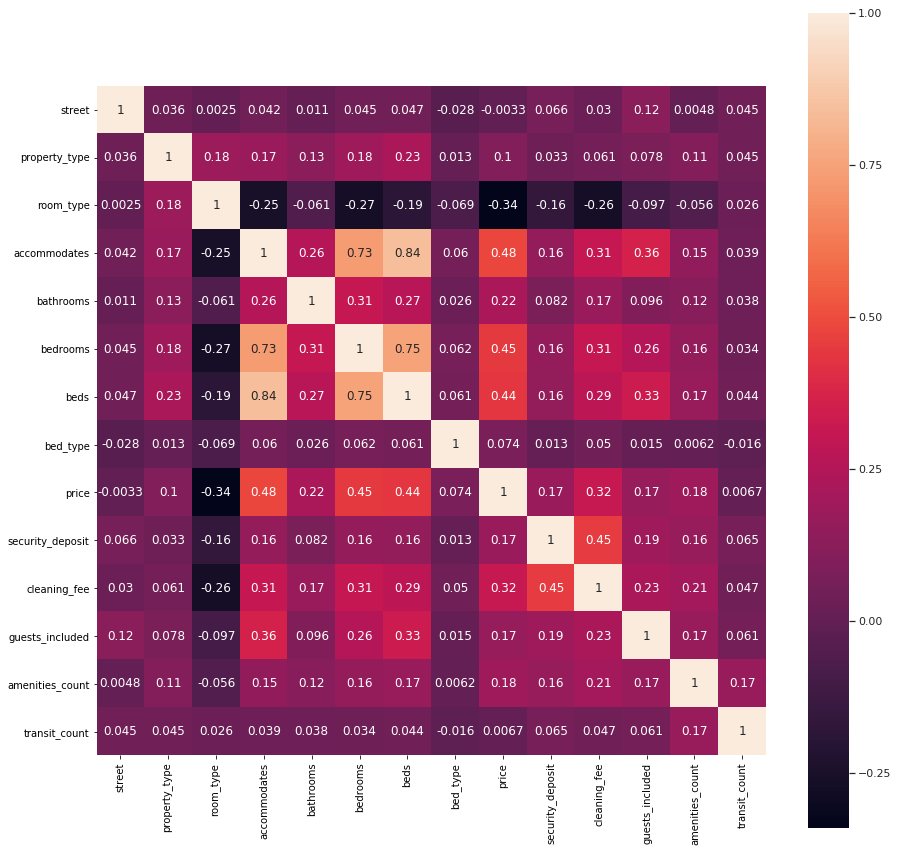

In [21]:
plot_heatmap(dataframe)

The pairplot of all the features

In [0]:
def plot_pairplot(dataframe):
    columns_list = list(dataframe.columns)
    columns_list.remove("price")
    sns.pairplot(dataframe,x_vars=columns_list[:7], y_vars=["price"], height=5, aspect=0.5, kind='reg')
    sns.pairplot(dataframe,x_vars=columns_list[7:], y_vars=["price"], height=5, aspect=0.5, kind='reg')
  

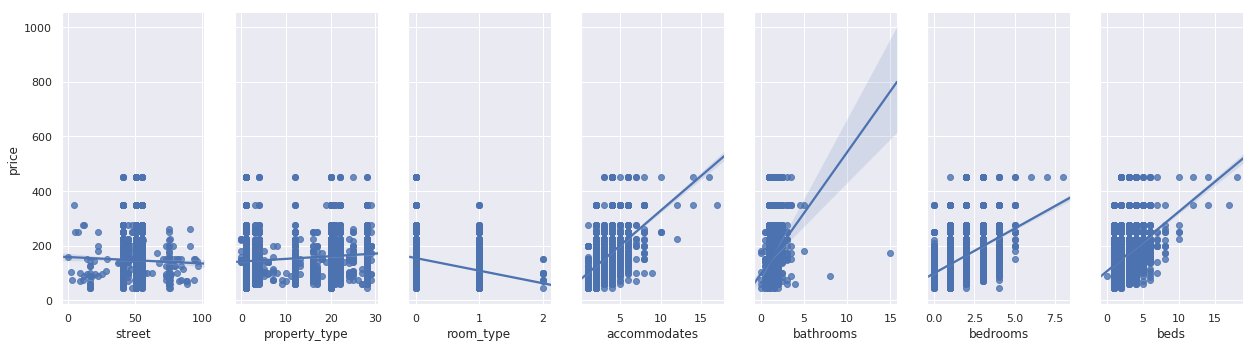

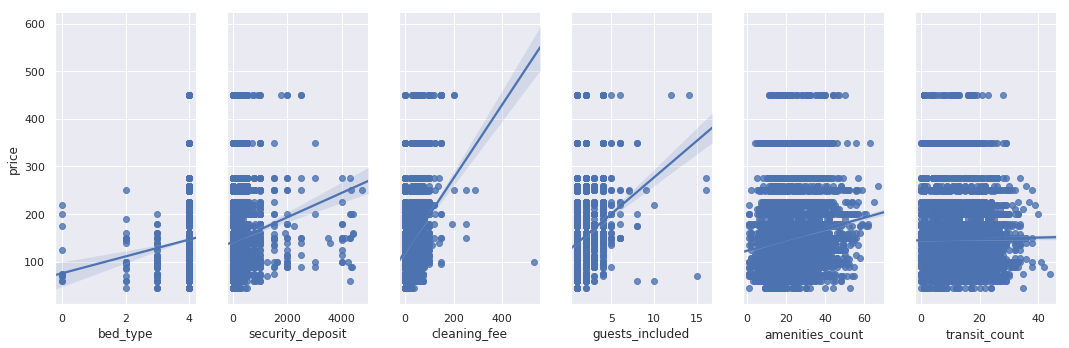

In [23]:
plot_pairplot(dataframe)

**Perform PCA for analysing the performance of model and store it in a new dataframe.**

In [0]:
def perform_PCA(dataframe):
    Y_frame = dataframe["price"]
    X_frame = dataframe.drop("price", axis = 1)
  
    pca = PCA(n_components=12)
    X_new = pca.fit_transform(X_frame)
    new_df = pd.DataFrame(data=X_new)
    new_df['price'] = Y_frame
  
    return new_df

In [0]:
new_df = perform_PCA(dataframe)

**Perform Linear Regression**

In [0]:
def perform_linear_regression(X_frame, Y_frame, kFold):
    k_fold = KFold(n_splits = kFold)
    X_dataframe = np.array(X_frame)
    Y_dataframe = np.array(Y_frame)
    
    X_shuffled , predictions_shuffled = shuffle(X_dataframe, Y_dataframe, random_state=0)
    
    rms_errors = []
    mae_errors = []
  
    sc = StandardScaler()  
    linear_regression_model = LinearRegression()
    
    for train_index, test_index in k_fold.split(X_shuffled):
    
        X_train, X_test = X_shuffled[train_index], X_shuffled[test_index]
        y_train, y_test = predictions_shuffled[train_index], predictions_shuffled[test_index]
    
        
        X_train = sc.fit_transform(X_train)  
        X_test = sc.transform(X_test) 
        
        linear_regression_model.fit(X_train,y_train)
        predictions = linear_regression_model.predict(X_test)
    
    
        rmse = mean_squared_error(y_test,predictions)
        mae = mean_absolute_error(y_test,predictions)
    
    
        rms_errors.append(rmse)
        mae_errors.append(mae)
    
    print("RMSE for Linear Model", np.mean(rms_errors))
    print("MAE for Linear Model", np.mean(mae_errors))


In [27]:
Y_dataframe = new_df["price"]
X_dataframe = new_df.drop(["price"],axis = 1)

perform_linear_regression(X_dataframe,Y_dataframe , 10)


Y_dataframe = dataframe["price"]
X_dataframe = dataframe.drop(["price"],axis = 1)

perform_linear_regression(X_dataframe,Y_dataframe , 10)

RMSE for Linear Model 2475.285965949564
MAE for Linear Model 37.00985626763556
RMSE for Linear Model 2475.0325651323287
MAE for Linear Model 37.00816787119747


**Perform Decision Tree Regression**

In [0]:
def perform_decision_tree_regression(X_frame, Y_frame, kFold):
    k_fold = KFold(n_splits = kFold)
    X_dataframe = np.array(X_frame)
    Y_dataframe = np.array(Y_frame)
    
    X_shuffled , predictions_shuffled = shuffle(X_dataframe, Y_dataframe, random_state=0)
    
    rms_errors = []
    mae_errors = []
    sc = StandardScaler()  
    decision_tree_regression_model = DecisionTreeRegressor(criterion='mse', max_depth=10, max_leaf_nodes=500,\
                                                         min_samples_leaf=1, min_samples_split=2, random_state=0, splitter='best')
    
    for train_index, test_index in k_fold.split(X_shuffled):
    
        X_train, X_test = X_shuffled[train_index], X_shuffled[test_index]
        y_train, y_test = predictions_shuffled[train_index], predictions_shuffled[test_index]
        
        X_train = sc.fit_transform(X_train)  
        X_test = sc.transform(X_test) 
    
        decision_tree_regression_model.fit(X_train,y_train)
        predictions = decision_tree_regression_model.predict(X_test)
    
        rmse = mean_squared_error(y_test,predictions)
        mae = mean_absolute_error(y_test,predictions)
    
        rms_errors.append(rmse)
        mae_errors.append(mae)
    
    print("RMSE for Decision Tree Model", np.mean(rms_errors))
    print("MAE for Decision Tree Model", np.mean(mae_errors))

In [29]:
Y_dataframe = new_df["price"]
X_dataframe = new_df.drop(["price"],axis = 1)

perform_decision_tree_regression(X_dataframe,Y_dataframe , 10)


Y_dataframe = dataframe["price"]
X_dataframe = dataframe.drop(["price"],axis = 1)

perform_decision_tree_regression(X_dataframe,Y_dataframe , 15)


RMSE for Decision Tree Model 3474.6936924219467
MAE for Decision Tree Model 41.493818067612594
RMSE for Decision Tree Model 2946.802237538897
MAE for Decision Tree Model 38.81286986502199


**Perform KNN regression**

In [0]:
def perform_K_nearest_regression(X_frame, Y_frame, neighbours, kFold):
    
    X_dataframe = np.array(X_frame)
    Y_dataframe = np.array(Y_frame)
    k_fold = KFold(n_splits = kFold)
  
    X_shuffled , predictions_shuffled = shuffle(X_dataframe, Y_dataframe, random_state=0)
    
    rms_errors = []
    mae_errors = []
    
    kNN_regression_model = KNeighborsRegressor(n_neighbors = neighbours)
    sc = StandardScaler()  
    
    for train_index, test_index in k_fold.split(X_shuffled):
    
        X_train, X_test = X_shuffled[train_index], X_shuffled[test_index]
        y_train, y_test = predictions_shuffled[train_index], predictions_shuffled[test_index]
        
        X_train = sc.fit_transform(X_train)  
        X_test = sc.transform(X_test) 
    
        kNN_regression_model.fit(X_train,y_train)
        predictions = kNN_regression_model.predict(X_test)
   
        rmse = mean_squared_error(y_test,predictions)
        mae = mean_absolute_error(y_test,predictions)
    
        rms_errors.append(rmse)
        mae_errors.append(mae)
    
    print("RMSE for K Nearest Neighbour Model", np.mean(rms_errors))
    print("MAE for K Nearest Neighbour Model", np.mean(mae_errors))
  

In [31]:
Y_dataframe = new_df["price"]
X_dataframe = new_df.drop(["price"],axis = 1)

perform_K_nearest_regression(X_dataframe,Y_dataframe , 10,10)


Y_dataframe = dataframe["price"]
X_dataframe = dataframe.drop("price",axis = 1)

perform_K_nearest_regression(X_dataframe,Y_dataframe ,10, 10)

RMSE for K Nearest Neighbour Model 2571.5805791075045
MAE for K Nearest Neighbour Model 37.16175456389452
RMSE for K Nearest Neighbour Model 2550.443036511156
MAE for K Nearest Neighbour Model 37.183022312373225


**Perform Random Forest Regression**

In [0]:
def random_forest_feature_importance(important_features_dict,column_names):
    important_features_list = sorted(important_features_dict,key=important_features_dict.get,\
                                 reverse=True)
    #print ('Most important features: %s' %important_features_dict)
  
    column_sorted =[]
    column_importance_sorted =[]
  
    for key in important_features_list:
        column_sorted.append(column_names[key])
        column_importance_sorted.append(important_features_dict[key])
    
    plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.title('Feature Importances')
    plt.barh(range(len(column_importance_sorted)), column_importance_sorted, color='b', align='center')
    plt.yticks(range(len(column_importance_sorted)), column_sorted)
    plt.xlabel('Relative Importance')
    # plt.figure(figsize = (100,80))
    plt.show()
  
  
def perform_random_forest_regression(X_frame, Y_frame, kFold):
    X_dataframe = np.array(X_frame)
    Y_dataframe = np.array(Y_frame)
    k_fold = KFold(n_splits = kFold)
  
    X_shuffled , predictions_shuffled = shuffle(X_dataframe, Y_dataframe, random_state=0)
    
    rms_errors = []
    mae_errors = []
  
    random_forest_regression_model = RandomForestRegressor(n_estimators=20, random_state=0)  
    sc = StandardScaler()  
    
  
    for train_index, test_index in k_fold.split(X_shuffled):
    
        X_train, X_test = X_shuffled[train_index], X_shuffled[test_index]
        y_train, y_test = predictions_shuffled[train_index], predictions_shuffled[test_index]
    
        X_train = sc.fit_transform(X_train)  
        X_test = sc.transform(X_test)  
        
        random_forest_regression_model.fit(X_train,y_train)
        predictions = random_forest_regression_model.predict(X_test)
    
        rmse = mean_squared_error(y_test,predictions)
        mae = mean_absolute_error(y_test,predictions)
    
        rms_errors.append(rmse)
    
        mae_errors.append(mae)
      
    print("RMSE for Random Forest Regression Model", np.mean(rms_errors))
  
    print("MAE for Random Forest Regression Model", np.mean(mae_errors))
  
    important_features_dict = {}
    
    for x,i in enumerate(random_forest_regression_model.feature_importances_):
        important_features_dict[x]=i
    
    return important_features_dict

RMSE for Random Forest Regression Model 2569.540902169897
MAE for Random Forest Regression Model 37.83125569350169
RMSE for Random Forest Regression Model 2581.477363854421
MAE for Random Forest Regression Model 37.828008588422506


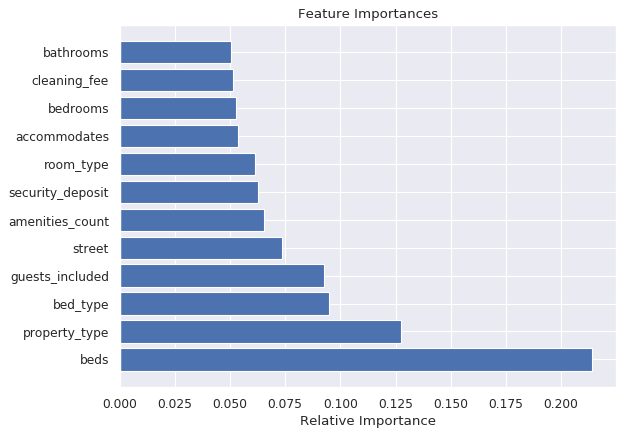

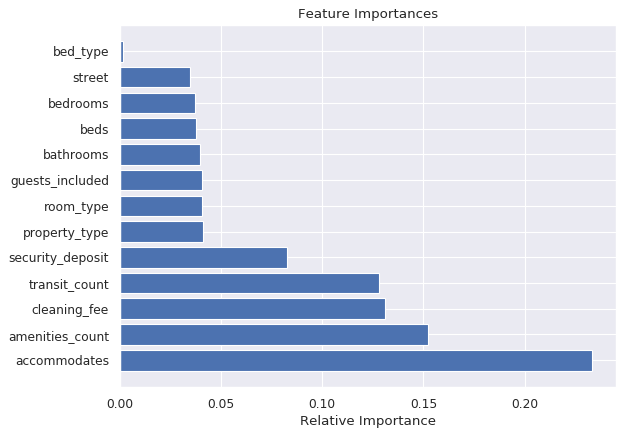

In [33]:
Y_dataframe = new_df["price"]
X_dataframe = new_df.drop(["price"],axis = 1)

important_features_dict_pca = perform_random_forest_regression(X_dataframe,Y_dataframe , 10)


Y_dataframe = dataframe["price"]
X_dataframe = dataframe.drop("price",axis = 1)

important_features_dict = perform_random_forest_regression(X_dataframe,Y_dataframe , 10)

random_forest_feature_importance(important_features_dict_pca,list(X_dataframe.columns))
random_forest_feature_importance(important_features_dict,list(X_dataframe.columns))

**Perfrorm Ridge Regression**

In [0]:

def perform_ridge_regression(X_frame, Y_frame, kFold, alpha):
    X_dataframe = np.array(X_frame)
    Y_dataframe = np.array(Y_frame)
    k_fold = KFold(n_splits = kFold)
  
    X_shuffled , predictions_shuffled = shuffle(X_dataframe, Y_dataframe, random_state=0)
    
    rms_errors = []
    mae_errors = []
  
    ridge_regression_model = Ridge(alpha=alpha) #  comparison with alpha value
 
    sc = StandardScaler()  
    
  
    for train_index, test_index in k_fold.split(X_shuffled):
    
        X_train, X_test = X_shuffled[train_index], X_shuffled[test_index]
        y_train, y_test = predictions_shuffled[train_index], predictions_shuffled[test_index]
    
        X_train = sc.fit_transform(X_train)  
        X_test = sc.transform(X_test)  
        
        ridge_regression_model.fit(X_train,y_train)
        predictions = ridge_regression_model.predict(X_test)
    
        rmse = mean_squared_error(y_test,predictions)
        mae = mean_absolute_error(y_test,predictions)
    
        rms_errors.append(rmse)
    
        mae_errors.append(mae)
      
    print("RMSE for Ridge Regression Model", np.mean(rms_errors))
  
    print("MAE for Ridge Regression Model", np.mean(mae_errors))
  
  

In [35]:
Y_dataframe = new_df["price"]
X_dataframe = new_df.drop(["price"],axis = 1)

perform_ridge_regression(X_dataframe,Y_dataframe , 10, 0.005)


Y_dataframe = dataframe["price"]
X_dataframe = dataframe.drop("price",axis = 1)

perform_ridge_regression(X_dataframe,Y_dataframe , 10, 0.005)


RMSE for Ridge Regression Model 2475.285960306424
MAE for Ridge Regression Model 37.009856421088124
RMSE for Ridge Regression Model 2475.0325559947973
MAE for Ridge Regression Model 37.00816804618148
